In [1]:
!pip install numpy matplotlib keras opencv-python scikit-learn pandas tensorflow

In [2]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
certifi                      2024.2.2
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
exceptiongroup               1.2.1
executing                    2.0.1
flatbuffers                  24.3.25
fonttools                    4.51.0
gast                         0.5.4
google-pasta                 0.2.0
grpcio                       1.63.0
h5py                         3.11.0
idna                         3.7
importlib_metadata           7.1.0
importlib_resources          6.4.0
ipykernel                    6.29.4
ipython                      8.18.1
jedi                         0.19.1
joblib                       1.4.0
ju

In [3]:
###############################
############################### Training Code
###############################
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
################# Parameters #####################
path = "myData"  # folder with all the class folders
labelFile = "labels.csv"  # file with all names of classes
batch_size_val = 50  # how many to process together
steps_per_epoch_val = 2000
epochs_val = 20
imageDimensions = (32, 32, 3)
testRatio = 0.2  # if 1000 images split will 200 for testing
validationRatio = 0.2  # if 1000 images 20% of remaining 800 will be 160 for validation

In [5]:
############################### Importing of the Images
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Total Classes Detected:", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [6]:
############################### Split Data
X_train, X_test, y_train, y_test = train_test_split(
    images, classNo, test_size=testRatio
)
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=validationRatio
)
steps_per_epoch_val = len(X_train) // batch_size_val
validation_steps = len(X_test) // batch_size_val

# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID

In [7]:
############################### TO CHECK IF NUMBER OF IMAGES MATCHES TO NUMBER OF LABELS FOR EACH DATA SET
print("Data Shapes")
print("Train", end="")
print(X_train.shape, y_train.shape)
print("Validation", end="")
print(X_validation.shape, y_validation.shape)
print("Test", end="")
print(X_test.shape, y_test.shape)
assert (
    X_train.shape[0] == y_train.shape[0]
), "The number of images in not equal to the number of labels in training set"
assert (
    X_validation.shape[0] == y_validation.shape[0]
), "The number of images in not equal to the number of labels in validation set"
assert (
    X_test.shape[0] == y_test.shape[0]
), "The number of images in not equal to the number of labels in test set"
assert X_train.shape[1:] == (
    imageDimensions
), " The dimensions of the Training images are wrong "
assert X_validation.shape[1:] == (
    imageDimensions
), " The dimensions of the Validation images are wrong "
assert X_test.shape[1:] == (
    imageDimensions
), " The dimensions of the Test images are wrong"

Data Shapes
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


In [8]:
############################### READ CSV FILE
data = pd.read_csv(labelFile)
print("data shape ", data.shape, type(data))

data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


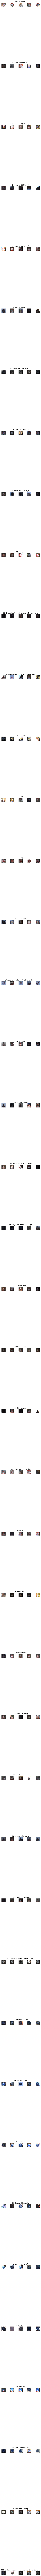

In [9]:
############################### DISPLAY SOME SAMPLES IMAGES  OF ALL THE CLASSES
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(
            x_selected[random.randint(0, len(x_selected) - 1), :, :],
            cmap=plt.get_cmap("gray"),
        )
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["Name"])
            num_of_samples.append(len(x_selected))

[114, 1259, 1284, 810, 1137, 1081, 225, 846, 788, 853, 1167, 746, 1198, 1254, 427, 351, 218, 608, 686, 102, 183, 151, 212, 303, 166, 849, 339, 135, 300, 158, 252, 434, 138, 395, 237, 700, 208, 108, 1200, 173, 193, 142, 141]


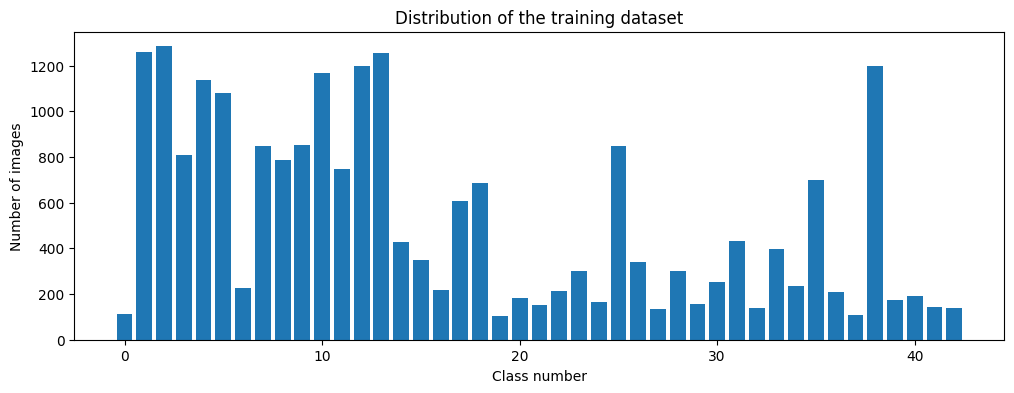

In [10]:
############################### DISPLAY A BAR CHART SHOWING NO OF SAMPLES FOR EACH CATEGORY
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [11]:
############################### PREPROCESSING THE IMAGES
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img


def equalize(img):
    img = cv2.equalizeHist(img)
    return img


def preprocessing(img):
    img = grayscale(img)  # CONVERT TO GRAYSCALE
    img = equalize(img)  # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img / 255  # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    return img


X_train = np.array(
    list(map(preprocessing, X_train))
)  # TO ITERATE AND PREPROCESS ALL IMAGES
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))
cv2.imshow(
    "GrayScale Images", X_train[random.randint(0, len(X_train) - 1)]
)  # TO CHECK IF THE TRAINING IS DONE PROPERLY

In [12]:
############################### ADD A DEPTH OF 1
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(
    X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1
)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

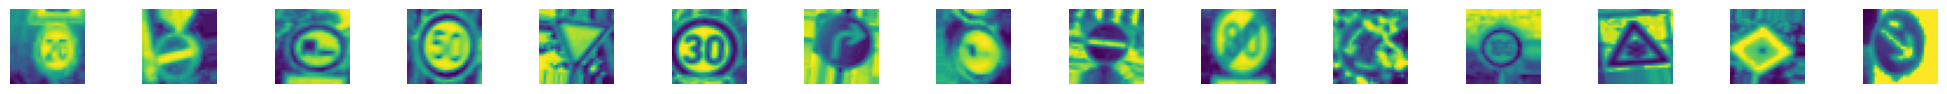

In [13]:
############################### AUGMENTATION OF IMAGES: TO MAKEIT MORE GENERIC
dataGen = ImageDataGenerator(
    width_shift_range=0.1,  # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFERS TO NO. OF  PIXELS EG 10 PIXELS
    height_shift_range=0.1,
    zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
    shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
    rotation_range=10,
)  # DEGREES
dataGen.fit(X_train)
batches = dataGen.flow(
    X_train, y_train, batch_size=20
)  # REQUESTING DATA GENERATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREATED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)

# TO SHOW AUGMENTED IMAGE SAMPLES
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimensions[0], imageDimensions[1]))
    axs[i].axis("off")
plt.show()


y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [14]:
############################### CONVOLUTION NEURAL NETWORK MODEL
def myModel():
    no_Of_Filters = 60
    size_of_Filter = (
        5,
        5,
    )  # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
    # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2 = (3, 3)
    size_of_pool = (
        2,
        2,
    )  # SCALE DOWN ALL FEATURE MAP TO GENERALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500  # NO. OF NODES IN HIDDEN LAYERS
    model = Sequential()
    model.add(
        (
            Conv2D(
                no_Of_Filters,
                size_of_Filter,
                input_shape=(imageDimensions[0], imageDimensions[1], 1),
                activation="relu",
            )
        )
    )  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation="relu")))
    model.add(
        MaxPooling2D(pool_size=size_of_pool)
    )  # DOES NOT EFFECT THE DEPTH/NO OF FILTERS

    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation="relu")))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation="relu")))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes, activation="relu"))
    model.add(Dropout(0.5))  # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noOfClasses, activation="softmax"))  # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(
        Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [15]:
############################### TRAIN
model = myModel()
print(model.summary())
history = model.fit(
    dataGen.flow(X_train, y_train, batch_size=batch_size_val),
    steps_per_epoch=steps_per_epoch_val,
    epochs=epochs_val,
    validation_data=(X_validation, y_validation),
    shuffle=1,
)

f:\Tutorial\learn-traffic-sign-classification\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20


f:\Tutorial\learn-traffic-sign-classification\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


445/445 ━━━━━━━━━━━━━━━━━━━━ 33s 69ms/step - accuracy: 0.1471 - loss: 3.1873 - val_accuracy: 0.7469 - val_loss: 0.9737
Epoch 2/20
  1/445 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accuracy: 0.4200 - loss: 1.7351

C:\Users\agift\AppData\Local\Programs\Python\Python39\lib\contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4200 - loss: 1.7351 - val_accuracy: 0.7349 - val_loss: 0.9813
Epoch 3/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.5452 - loss: 1.4707 - val_accuracy: 0.9057 - val_loss: 0.4372
Epoch 4/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6600 - loss: 0.9956 - val_accuracy: 0.9127 - val_loss: 0.4207
Epoch 5/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.6939 - loss: 0.9831 - val_accuracy: 0.9450 - val_loss: 0.2169
Epoch 6/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7200 - loss: 0.9487 - val_accuracy: 0.9479 - val_loss: 0.2112
Epoch 7/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 29s 66ms/step - accuracy: 0.7720 - loss: 0.7178 - val_accuracy: 0.9607 - val_loss: 0.1469
Epoch 8/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8600 - loss: 0.4313 - val_accuracy: 0.9601 - val_loss: 0.1518
Epoch 9/20
445/445 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.8100 - loss: 0.5954 - val_accuracy: 0.965

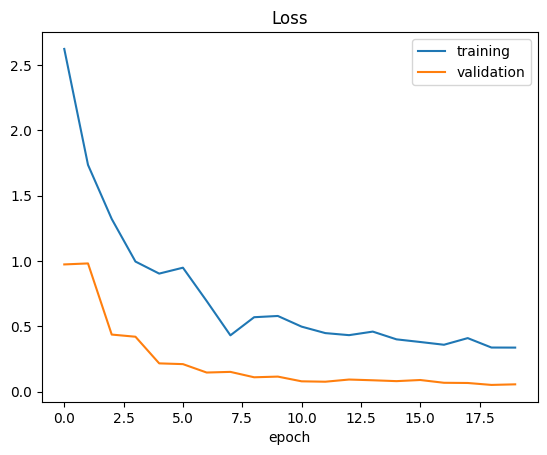

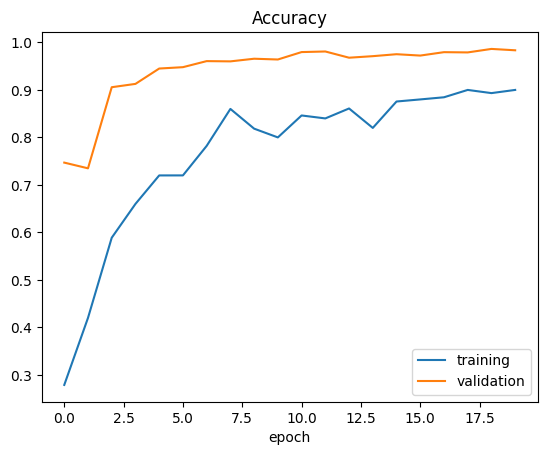

Test Score: 0.05970342457294464
Test Accuracy: 0.9850574731826782


In [16]:
############################### PLOT
plt.figure(1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["training", "validation"])
plt.title("Loss")
plt.xlabel("epoch")
plt.figure(2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["training", "validation"])
plt.title("Accuracy")
plt.xlabel("epoch")
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [17]:
# STORE THE MODEL AS A PICKLE OBJECT
pickle_out = open("model_trained.p", "wb")  # wb = WRITE BYTE
pickle.dump(model, pickle_out)
pickle_out.close()
cv2.waitKey(0)

-1